In [1]:
# from config.config import Config
import torch
from models.load_model import Model
from huggingface_hub import login
login(token="REMOVED")
# fix the seeds
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# model_name = "meta-llama/Llama-3.2-1B-Instruct"
# model_name = "EleutherAI/pythia-2.8b"
# model_name = "openai-community/gpt2-large"
# model_name = "meta-llama/Llama-2-7b-hf"
# model_name = "mistralai/Mistral-7B-v0.1"
# model_name = "meta-llama/Llama-3.1-8B"

/home/hilal/miniconda3/envs/hug1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import argparse

class ArgumentParser:
    def __init__(self):
        self.transform = "PCA"
        self.Tdim = 1
        self.k = 30
        self.num_examples = 3
        self.upper_bound = 100
        self.context = 'same'
        self.data = 'numerics'
        self.groups = [1,2,3,4]
        self.save = True
        self.plot = True
        self.model_name ="meta-llama/Llama-2-7b-hf"
        self.device = "0"
        self.start_over = False

args = ArgumentParser()

In [3]:
# Original: range(10**i - 2 * 10, 10**i + 2 * 10) if i >1 else range(1, 40)
interval_function = lambda i: range(10**i - 2 * 10, 10**i + 2 * 10) if i >1 else range(1, 40)
# Load the prompts data
from utils.data_utils import generate_prompts_numerals,generate_prompts_symbols
if args.data.lower() == 'numerics':
    prompts = generate_prompts_numerals(args.k, args.num_examples, args.upper_bound, args.groups,interval_function , context=args.context)
else:
    prompts = generate_prompts_symbols(args.k, args.num_examples, args.groups , context=args.context)


In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM
DEVICE = torch.device(f"cuda:{args.device}" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained( args.model_name)
model = AutoModelForCausalLM.from_pretrained( args.model_name).to(DEVICE)
model_num_layer = model.config.num_hidden_layers


Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.68s/it]


In [5]:
# Check if the result file already exists; if so, set a flag to False and skip further processing
import os
import pickle
save_dir = "ICLR_results"
filename = f"{args.model_name.replace('/', '_')}_{args.data}_k{args.k}_n{args.num_examples}.pkl"
save_path = os.path.join(save_dir, filename)
run_flag = True
if os.path.exists(save_path):
    print(f"Results file {save_path} already exists. Loading results from file.")
    with open(save_path, "rb") as f:
        results = pickle.load(f)
    run_flag = False


Results file ICLR_results/meta-llama_Llama-2-7b-hf_numerics_k30_n3.pkl already exists. Loading results from file.


## Collecting hidden state from all layers

In [8]:
# Initialize results: for each layer, store a dict with 'hidden_states' and 'answers'
if run_flag or args.start_over:
    print("Starting new experiment")
    results = {}
    for i in range(model_num_layer):
        results[i] = {'hidden_states': {}, 'answers': {}}

    with torch.no_grad():
        for group, prompt_list in prompts.items():
            group_hidden_states = {i: [] for i in range(model_num_layer)}
            group_answers = []
            for prompt in prompt_list:
                inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
                outputs = model(**inputs, output_hidden_states=True)
                last_number = prompt[prompt.rfind(',')+1:prompt.rfind('=')]
                last_token_rep_all_layers = [outputs.hidden_states[lyr][:, -1, :].detach().cpu() for lyr in range(model_num_layer)]
                for i in range(model_num_layer):
                    group_hidden_states[i].append(last_token_rep_all_layers[i])
                group_answers.append(last_number)
            for i in range(model_num_layer):
                results[i]['hidden_states'][group] = group_hidden_states[i]
                results[i]['answers'][group] = group_answers

    # Save the results dict 
    with open(save_path, "wb") as f:
        pickle.dump(results, f)
    print(f"Results saved to {save_path}")


## Finidng T projections and the three metrics for all layers

In [9]:
# Apply T(x) using PLS or PCA, but only recompute if start_over is True or files do not exist
from utils.compute_utils import transform_hidden_states, analyze_transformed_hidden_states
import os

transform_method = args.transform.upper()
results_T_filename = f"{filename}_results_transformed_{transform_method}.pkl"
results_analysis_filename = f"{filename}_results_analysis_{transform_method}.pkl"

results_T_path = os.path.join(save_dir, results_T_filename)
results_analysis_path = os.path.join(save_dir, results_analysis_filename)

load_existing = (
    os.path.exists(results_T_path) and 
    os.path.exists(results_analysis_path) and 
    not getattr(args, "start_over", False)
)

if load_existing:
    print(f"Found existing transformed results at {results_T_path} and analysis at {results_analysis_path}. Loading from files.")
    with open(results_T_path, "rb") as f:
        results_T = pickle.load(f)
    with open(results_analysis_path, "rb") as f:
        results_analysis = pickle.load(f)
else:
    print("Computing transformed hidden states and analysis...")
    results_T = transform_hidden_states(results, args.transform, args.Tdim)
    results_analysis = analyze_transformed_hidden_states(results_T)
    with open(results_T_path, "wb") as f:
        pickle.dump(results_T, f)
    with open(results_analysis_path, "wb") as f:
        pickle.dump(results_analysis, f)
    print(f"results_T saved to {results_T_path}")
    print(f"results_analysis saved to {results_analysis_path}")


Found existing transformed results at ICLR_results/meta-llama_Llama-2-7b-hf_numerics_k30_n3.pkl_results_transformed_PCA.pkl and analysis at ICLR_results/meta-llama_Llama-2-7b-hf_numerics_k30_n3.pkl_results_analysis_PCA.pkl. Loading from files.


## Causuality check

In [ ]:
import random
import re

def is_number(s):
    """Check if the string contains a number (int or float)."""
    # Only check the character after the last '='
    idx = s.rfind('=')
    if idx == -1 or idx == len(s) - 1:
        return False
    after_eq = s[idx+1:].strip()
    return bool(re.match(r'^-?\d+(\.\d+)?$', after_eq.split()[0])) if after_eq else False

def intervene_and_compare_outputs(model, tokenizer, prmpts, results_T, num_random=3, num_samples=10, device="cuda" if torch.cuda.is_available() else "cpu"):
    """
    For a random sample of prompts, for each layer, generate outputs for:
    - original (no intervention)
    - PCA direction intervention
    - random direction intervention

    At the end, print a summary of how many outputs are numbers for PCA and random interventions.
    """
    layers = list(results_T.keys())
    res = {i:{} for i in range(len(layers))}
    print(f"+++++++++Start epxeriemnts+++++++++++++")
    for layer in layers:
        
        pca_direction = results_T[layer]['First_direction']
        pca_direction = torch.tensor(pca_direction, dtype=torch.float32, device=device)
        hidden_dim = pca_direction.shape[0]
        random_directions = [torch.randn_like(pca_direction) for _ in range(num_random)]
        # pca_direction = pca_direction / (pca_direction.norm() + 1e-8)
        # random_directions = [v / (v.norm() + 1e-8) for v in random_directions]

        pca_num_count = 0
        rand_num_count = 0
        total = 0

        for i, prompt in enumerate(prmpts):
            # print(f"\nPrompt {i+1}: {repr(prompt)}")
            inputs = tokenizer(prompt, return_tensors="pt").to(device)

            # --- Original output (no intervention) ---
            with torch.no_grad():
                out_orig = model.generate(**inputs, max_new_tokens=2)
            decoded_orig = tokenizer.decode(out_orig[0], skip_special_tokens=True)
            # print(f"Original output: {repr(decoded_orig)}")

            # --- PCA direction intervention ---
            def hook_fn_pca(module, input, output):
                output = output.clone()
                output[0, -1] += 2*pca_direction
                return output

            handle_pca = model.model.layers[layer].register_forward_hook(hook_fn_pca)
            try:
                with torch.no_grad():
                    out_pca = model.generate(**inputs, max_new_tokens=2)
                decoded_pca = tokenizer.decode(out_pca[0], skip_special_tokens=True)
                # print(f"PCA intervened output: {repr(decoded_pca)}")
                if is_number(decoded_pca):
                    pca_num_count += 1
            except Exception as e:
                print(f"PCA intervention failed: {e}")
            finally:
                handle_pca.remove()

            # --- Random direction intervention ---
            rand_dir = random.choice(random_directions)
            def hook_fn_rand(module, input, output):
                output = output.clone()
                output[0, -1] += 2*rand_dir
                return output

            handle_rand = model.model.layers[layer].register_forward_hook(hook_fn_rand)
            try:
                with torch.no_grad():
                    out_rand = model.generate(**inputs, max_new_tokens=2)
                decoded_rand = tokenizer.decode(out_rand[0], skip_special_tokens=True)
                # print(f"Random intervened output: {repr(decoded_rand)}")
                if is_number(decoded_rand):
                    rand_num_count += 1
            except Exception as e:
                print(f"Random intervention failed: {e}")
            finally:
                handle_rand.remove()

            total += 1

        # print(f"\nSummary for Layer {layer}:")
        # print(f"  PCA intervention: {pca_num_count}/{total} outputs contained numbers")
        # print(f"  Random intervention: {rand_num_count}/{total} outputs contained numbers")
        # print(f"  (Original outputs are shown above for reference)\n")
        res[layer]['PCA_interventions'] = pca_num_count/total
        res[layer]['Random_interventions'] = rand_num_count/total
    return res
# Example usage:
prmpts = prompts[1]+prompts[2]
res = intervene_and_compare_outputs(model, tokenizer, prmpts, results_T)


+++++++++Start epxeriemnts+++++++++++++


In [136]:
# Save results_analysis with filename reflecting the transform method
results_analysis_filename = f"{filename}_intervAnalysis_{transform_method}.pkl"
path = os.path.join(save_dir, results_analysis_filename)

import pickle

with open(path, "wb") as f:
    pickle.dump(res, f)



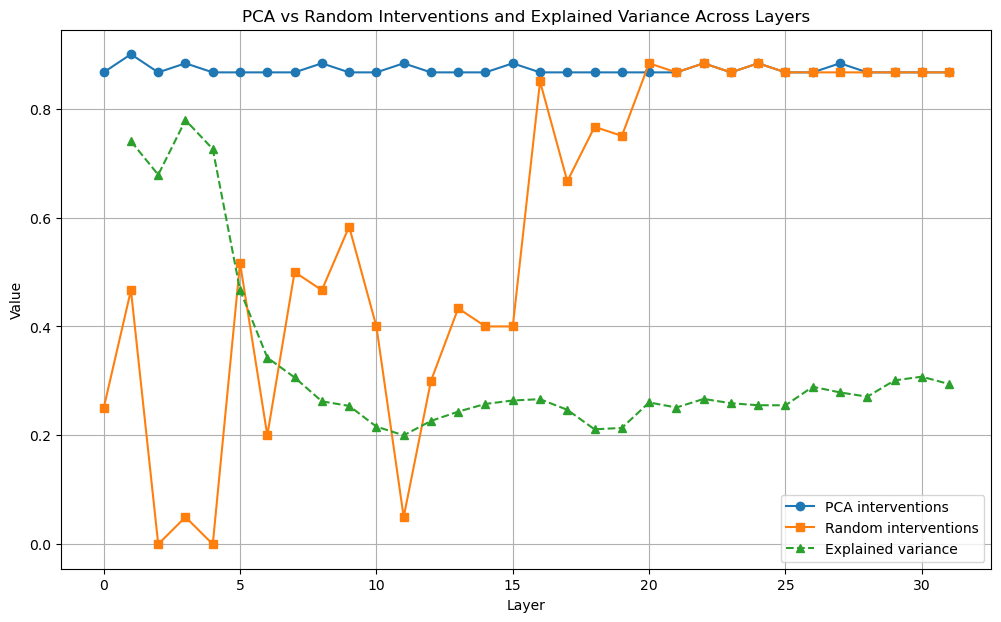

In [137]:
import matplotlib.pyplot as plt

layers = list(res.keys())
pca_vals = [res[layer]['PCA_interventions'] for layer in layers]
rand_vals = [res[layer]['Random_interventions'] for layer in layers]

# Get explained variance for each layer (assuming layers are 1-indexed in results_T)
explained_variance = [results_T[layer]['Explained_variance'] for layer in layers]

plt.figure(figsize=(12,7))
plt.plot(layers, pca_vals, marker='o', label='PCA interventions')
plt.plot(layers, rand_vals, marker='s', label='Random interventions')
plt.plot(layers, explained_variance, marker='^', label='Explained variance', linestyle='--')
plt.xlabel('Layer')
plt.ylabel('Value')
plt.title('PCA vs Random Interventions and Explained Variance Across Layers')
plt.legend()
plt.grid(True)
plt.show()